In [ ]:
!pip install -qq BorutaShap
!pip install catboost --upgrade
!pip install catboost-widget --upgrade
!pip install ipywidgets==7.6.3

In [2]:
import warnings
warnings.filterwarnings("ignore")
import time

from sklearn.model_selection import train_test_split, KFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

from scipy import stats

from catboost import CatBoostClassifier, Pool
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
import catboost

In [100]:
def check_split_equality(x_train, x_test, estimator=None, params=None, categorical=None, textual=None):
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    if isinstance(x_train, np.ndarray):
        x_inspect = np.concatenate([x_train, x_test], axis=0)
    else:
        x_inspect = pd.concat([x_train, x_test], axis=0)
    y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

    if params is None:
        params = {'depth': 4,
                  'iterations': 100,
                  'silent': True,
                  'auto_class_weights': None,
                  'learning_rate': 0.1,
                  'random_seed': 42,
                  'cat_features': categorical,
                  'text_features': textual
        }
    if estimator is None:
        inspector = CatBoostClassifier(**params)
    else:
        inspector = estimator

    cv = cross_val_score(
                         estimator=inspector,
                         X=x_inspect,
                         y=y_inspect,
                         scoring="roc_auc",
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    )
    return round(np.mean(cv), 4), round(np.std(cv), 4)

def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> list:
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true, n_samples=n_samlpes)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> tuple:
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

def print_scores(folds_scores, train_scores):
    print(f"Train score by each fold: {train_scores}")
    print(f"Valid score by each fold: {folds_scores}")
    print(f"Train mean score by each fold:{np.mean(train_scores):.5f} +/- {np.std(train_scores):.5f}")
    print(f"Valid mean score by each fold:{np.mean(folds_scores):.5f} +/- {np.std(folds_scores):.5f}")
    print("*" * 50)

def catboost_cross_validation(X: pd.DataFrame,
                              y: pd.Series,
                              params: dict = None,
                              cv=None,
                              categorical: list = None,
                              textual: list = None,
                              rounds: int = 50,
                              verbose: bool = True,
                              preprocess: object = None,
                              score_fn: callable = roc_auc_score,
                              calculate_ci: bool = False,
                              n_samples: int = 5000,
                              confidence: float = 0.95,
                              best_iter: str = "median",
                              not_best_model: bool = False,
                              is_raw: bool = False,
                              threshold: float = 0.5,
                              check_equality: bool = False,
                              seed: int = 42):
    import functools
    if isinstance(score_fn, functools.partial):
        score_fn_name = score_fn.func.__name__
    else:
        score_fn_name = score_fn.__name__

    minor_class_counts = y.value_counts(normalize=True).values[-1]

    if cv is None:
        if minor_class_counts >= 0.05:
            cv = KFold(n_splits=5, shuffle=True, random_state=seed)
        else:
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    if params is None:
        if len(X) <= 50_000:
            sub_params = {
                "grow_policy": "SymmetricTree",
                "boosting_type": "Ordered",
                "score_function": "Cosine",
                "depth": 6,
                "sampling_frequency": "PerTreeLevel",
                # Frequency to sample weights and objects when building trees, that are used to select objects
                # (Bayesian - strengthen random, Bernoulli - random, MVS - based on gradients size)
                # Bernoulli, MVS - random or gradient based subsample, Bayesian: uses all objects with bayesian
                # bootstrap instead of subsample
            }
        else:
            sub_params = {
                "grow_policy": "Lossguide",
                "boosting_type": "Plain",
                "score_function": "L2",
                "depth": 16,
                "min_data_in_leaf": 200,
                "max_leaves": 2 ** 16 // 8,
                "sampling_frequency": "PerTree",
            }
        params = {
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": seed,
            "allow_writing_files": False,
            "auto_class_weights": "SqrtBalanced" if minor_class_counts < 0.05 else None,
            "bagging_temperature": 1,
            "max_bin": 255,
            "l2_leaf_reg": 10,
            "subsample": 0.9,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.9,
            "random_strength": 1,
        }
        params.update(sub_params)

    if is_raw:
        prediction_type = "RawFormulaVal"
    else:
        prediction_type = "Probability" if score_fn_name == "roc_auc_score" else "Class"

    estimators, folds_scores, train_scores = [], [], []

    oof_preds = np.zeros(X.shape[0])

    if verbose:
        print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
        print("Estimating best number of trees.")

    best_iterations, equality = [], []

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        if preprocess is not None:
            x_train = preprocess.fit_transform(x_train, y_train)
            x_valid = preprocess.transform(x_valid)

        if check_equality:
            mean, std = check_split_equality(x_train, x_valid, categorical=categorical, textual=textual)
            equality.append((mean, std))

        train_pool = Pool(x_train, y_train, cat_features=categorical, text_features=textual)
        valid_pool = Pool(x_valid, y_valid, cat_features=categorical, text_features=textual)

        model = CatBoostClassifier(**params).fit(
            train_pool,
            eval_set=valid_pool,
            early_stopping_rounds=rounds
        )

        best_iterations.append(model.get_best_iteration())

    if best_iter == "median":
        best_iteration = int(np.median(best_iterations))
    elif best_iter == "mean":
        best_iteration = int(np.mean(best_iterations))
    else:
        raise NotImplementedError("Set best_iter median or mean")
    if verbose:
        print("Best iterations:", *best_iterations)

    params["iterations"] = best_iteration
    if not_best_model:
        params["use_best_model"] = False
        # as we estimated best cv number of trees and want our valid set to be fully independent of training process

    cv.random_state = seed % 3
    if verbose:
        print(f"Evaluating cross validation with {best_iteration} trees.")
        if check_equality:
            means, stds = list(zip(*equality))
            print("Split check on number of tree estimation: ", np.round(np.mean(means), 4), " +/- ",
                  np.round(np.max(stds), 4))

    equality = []
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        if preprocess is not None:
            x_train = preprocess.fit_transform(x_train, y_train)
            x_valid = preprocess.transform(x_valid)

        if check_equality:
            mean, std = check_split_equality(x_train, x_valid, categorical=categorical, textual=textual)
            equality.append((mean, std))

        train_pool = Pool(x_train, y_train, cat_features=categorical, text_features=textual)
        valid_pool = Pool(x_valid, y_valid, cat_features=categorical, text_features=textual)

        model = CatBoostClassifier(**params).fit(
            train_pool,
            eval_set=valid_pool,
        )

        train_score = catboost.CatBoost.predict(model, train_pool, prediction_type=prediction_type)
        if is_raw:
            exp = np.exp(train_score)
            train_score = exp / (1 + exp)
            if score_fn_name != "roc_auc_score":
                train_score = (train_score >= threshold).astype(np.uint8)

        if prediction_type == "Probability":
            train_score = train_score[:, 1]
        train_score = score_fn(y_train, train_score)

        valid_scores = catboost.CatBoost.predict(model, valid_pool, prediction_type=prediction_type)
        if prediction_type == "Probability":
            valid_scores = valid_scores[:, 1]

        if is_raw:
            exp = np.exp(valid_scores)
            valid_scores = exp / (1 + exp)
            if score_fn_name != "roc_auc_score":
                valid_scores = (valid_scores >= threshold).astype(np.uint8)

        oof_preds[valid_idx] = valid_scores
        score = score_fn(y_valid, oof_preds[valid_idx])

        folds_scores.append(round(score, 5))
        train_scores.append(round(train_score, 5))

        if verbose:
            print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
        estimators.append(model)

    if verbose:
        if check_equality:
            means, stds = list(zip(*equality))
            print("Split check while cross-validating: ", np.round(np.mean(means), 4), " +/- ",
                  np.round(np.max(stds), 4))
        oof_scores = score_fn(y, oof_preds)
        print_scores(folds_scores, train_scores)
        print(f"OOF-score {score_fn_name}: {oof_scores:.5f}")
        if calculate_ci:
            bootstrap_scores = create_bootstrap_metrics(y, oof_preds, score_fn, n_samlpes=n_samples)
            left_bound, right_bound = calculate_confidence_interval(bootstrap_scores, conf_interval=confidence)
            print(f"Expected metric value lies between: {left_bound:.5f} and {right_bound:.5f}",
                  f"with confidence of {confidence * 100}%")

    return estimators, oof_preds, np.mean(folds_scores)


def compare_models(oof_preds: list,
                   y_true: np.ndarray,
                   metric: callable,
                   n_train: int,
                   n_test: int,
                   model_names=None,
                   sample: int = 0,
                   conf_level: float = 0.95,
                   rope_interval: list = [-0.01, 0.01],
                   n_samples: int = 3000) -> pd.DataFrame:
    from scipy.stats import t, ttest_rel
    from itertools import combinations
    from math import factorial

    if model_names is None:
        model_names = [f"model_{i + 1}" for i in range(len(oof_preds))]

    n_comparisons = (factorial(len(oof_preds)) / (factorial(2) * factorial(len(oof_preds) - 2)))
    scores = [np.array(create_bootstrap_metrics(y_true, oof_pred, metric, n_samples)) for oof_pred in oof_preds]
    if sample != 0:
        scores = [np.random.choice(score, size=sample) for score in scores]

    df = scores[0].shape[0] - 1

    def corrected_std(differences, n_train, n_test):
        kr = len(differences)
        corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
        corrected_std = np.sqrt(corrected_var)
        return corrected_std

    def compute_corrected_ttest(differences, df, n_train, n_test):
        mean = np.mean(differences)
        std = corrected_std(differences, n_train, n_test)
        t_stat = mean / std
        p_val = t.sf(np.abs(t_stat), df)
        return t_stat, p_val

    pairwise_ttest, pairwise_bayesian, t_rel = [], [], []

    for model_i, model_k in combinations(range(len(scores)), r=2):
        model_i_scores = scores[model_i]
        model_k_scores = scores[model_k]

        differences = model_i_scores - model_k_scores
        t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
        p_val *= n_comparisons  # bonferroni correction
        p_val = 1 if p_val > 1 else p_val

        pairwise_ttest.append([model_names[model_i], model_names[model_k], t_stat, p_val])

        t_post = t(df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test))
        model_i_prob = t_post.cdf(rope_interval[0])  # probability of model 1 worse than 2
        model_k_prob = 1 - t_post.cdf(rope_interval[1])  # probability of model 2 worse than 1

        rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])  # probability of model 1 is equal 2

        cred_interval = list(t_post.interval(conf_level))  # true difference lies inside interval
        pairwise_bayesian.append([model_i_prob, model_k_prob, rope_prob, cred_interval[0], cred_interval[1]])

        tres = ttest_rel(model_i_scores, model_k_scores)
        statistic, p_val = tres[0], tres[1]
        # ci = tres.confidence_interval(confidence_level=0.95)

        t_rel.append([statistic, p_val])

    result = pd.DataFrame(data=np.hstack([pairwise_ttest, pairwise_bayesian, t_rel]),
                          index=[f"compare_{i + 1}" for i in range(int(n_comparisons))],
                          columns=["model_1", "model_2", "t_stat", "corr_p_val", "1_worse_2",
                                   "2_worse_1", "2_equal_1", "ci_lower", "ci_upper", "rel_stat", "non_corr_p_val"])
    result.iloc[:, 2:] = result.iloc[:, 2:].astype("float").apply(lambda x: np.round(x, 4))

    return result

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv", index_col="id")
TARGET = "Machine failure"
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [5]:
test = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv", index_col="id")
# + inspect outliers, distributions (how to make normal) -> new features
# + target distribution
# + what happend with Tool wear [min] first bin?

In [29]:
check_split_equality(df.drop(TARGET, axis=1), test, categorical=["Product ID", "Type"])  # almost equal distributions

(0.4975, 0.0027)

In [5]:
df.describe()  # all numerical features are nearly normally distributed

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
test.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.00000,90954.000000
mean,299.859493,309.939375,1520.528179,40.335191,104.293962,0.001473,0.005343,0.002353,0.00387,0.002309
std,1.857562,1.385296,139.970419,8.504683,63.871092,0.038355,0.072903,0.048449,0.06209,0.047995
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,300.000000,310.000000,1493.000000,40.500000,106.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,301.200000,310.900000,1579.000000,46.200000,158.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [7]:
df.describe(include="object")  # high and low cardinality

,Product ID,Type
count,136429,136429
unique,9976,3
top,L53257,L
freq,139,95354


In [9]:
df[TARGET].value_counts(normalize=True)  # imbalanced: resampling, class weights, focal loss

0    0.984256
1    0.015744
Name: Machine failure, dtype: float64

In [10]:
df.Type.value_counts()

L    95354
M    32152
H     8923
Name: Type, dtype: int64

<Axes: >

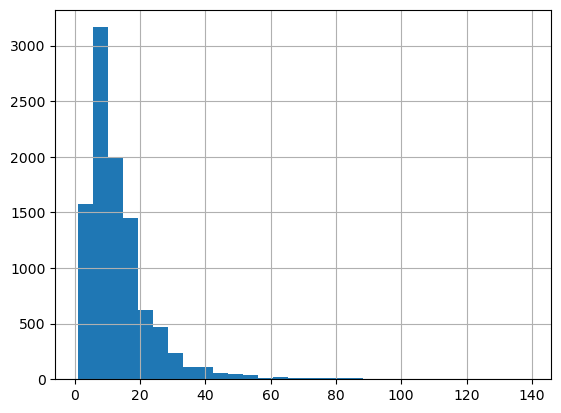

In [12]:
df["Product ID"].value_counts().hist(bins=30)

In [13]:
df.info()  # no missing values - good

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


In [20]:
df.groupby("Type")["Tool wear [min]"].mean()  # all feature mean values are visually close with Type grouping

Type
H    104.949793
L    104.113996
M    105.133398
Name: Tool wear [min], dtype: float64

<Axes: >

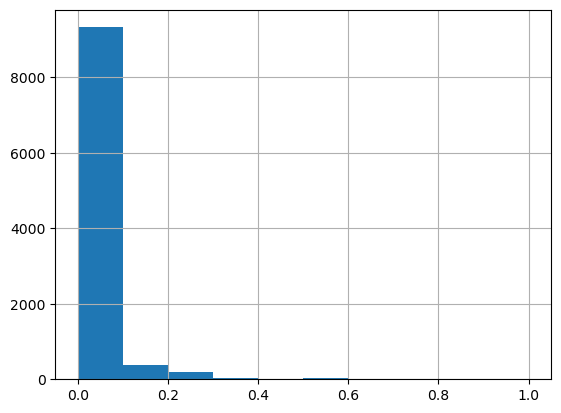

In [22]:
df.groupby("Product ID")[TARGET].mean().hist()

In [23]:
df[df[TARGET] == 1].describe()  # more hours -> more failures

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.0,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,300.860242,310.280214,1453.563315,50.149395,132.957169,1.0,0.098696,0.324953,0.150838,0.249534,0.002793
std,2.004966,1.256133,283.389995,13.263687,73.542665,0.0,0.298323,0.468467,0.357974,0.432844,0.052790
min,295.600000,306.000000,1181.000000,3.800000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,299.100000,309.575000,1340.000000,45.600000,69.750000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,301.400000,310.400000,1369.000000,52.150000,149.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,302.400000,311.100000,1433.000000,58.500000,201.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
max,304.400000,313.600000,2886.000000,76.600000,253.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df[df[TARGET] == 0].describe()  # binary features are important due to mean values, lower speed, torque may indicate troubles

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,134281.000000,134281.000000,134281.000000,134281.000000,134281.000000,134281.0,134281.0,134281.000000,134281.000000,134281.000000,134281.000000
mean,299.846820,309.935645,1521.399148,40.191867,103.952234,0.0,0.0,0.000045,0.000022,0.000030,0.002249
std,1.855531,1.386470,134.904503,8.310852,63.696575,0.0,0.0,0.006684,0.004727,0.005458,0.047371
min,295.300000,305.800000,1183.000000,4.200000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.700000,1434.000000,34.600000,48.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1495.000000,40.300000,105.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,301.100000,310.900000,1581.000000,45.900000,158.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2874.000000,75.400000,253.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000


In [6]:
numerical_features = df.select_dtypes("number").columns.tolist()
cat_features = df.select_dtypes("object").columns.tolist()

In [32]:
test["Product ID"].isin(df["Product ID"]).sum(), test.shape

(90900, (90954, 12))

In [33]:
test[~test["Product ID"].isin(df["Product ID"])].describe()  # lower torque, lower air temperature, lower process temperature, all-zero binary features, higher speed, 
# probably less failures here

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.0,54.0,54.0,54.0,54.0
mean,299.822222,309.605556,1532.814815,38.924074,104.166667,0.0,0.0,0.0,0.0,0.0
std,2.724845,2.015451,122.101887,7.051480,63.911126,0.0,0.0,0.0,0.0,0.0
min,295.600000,306.200000,1242.000000,23.300000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,298.100000,308.075000,1450.500000,35.250000,44.000000,0.0,0.0,0.0,0.0,0.0
50%,299.250000,309.600000,1531.500000,37.700000,108.000000,0.0,0.0,0.0,0.0,0.0
75%,302.375000,311.175000,1586.000000,42.750000,165.250000,0.0,0.0,0.0,0.0,0.0
max,303.700000,313.100000,1880.000000,62.300000,205.000000,0.0,0.0,0.0,0.0,0.0


In [34]:
test[~test["Product ID"].isin(df["Product ID"])].groupby("Type")["Product ID"].count()

Type
H    23
L    15
M    16
Name: Product ID, dtype: int64

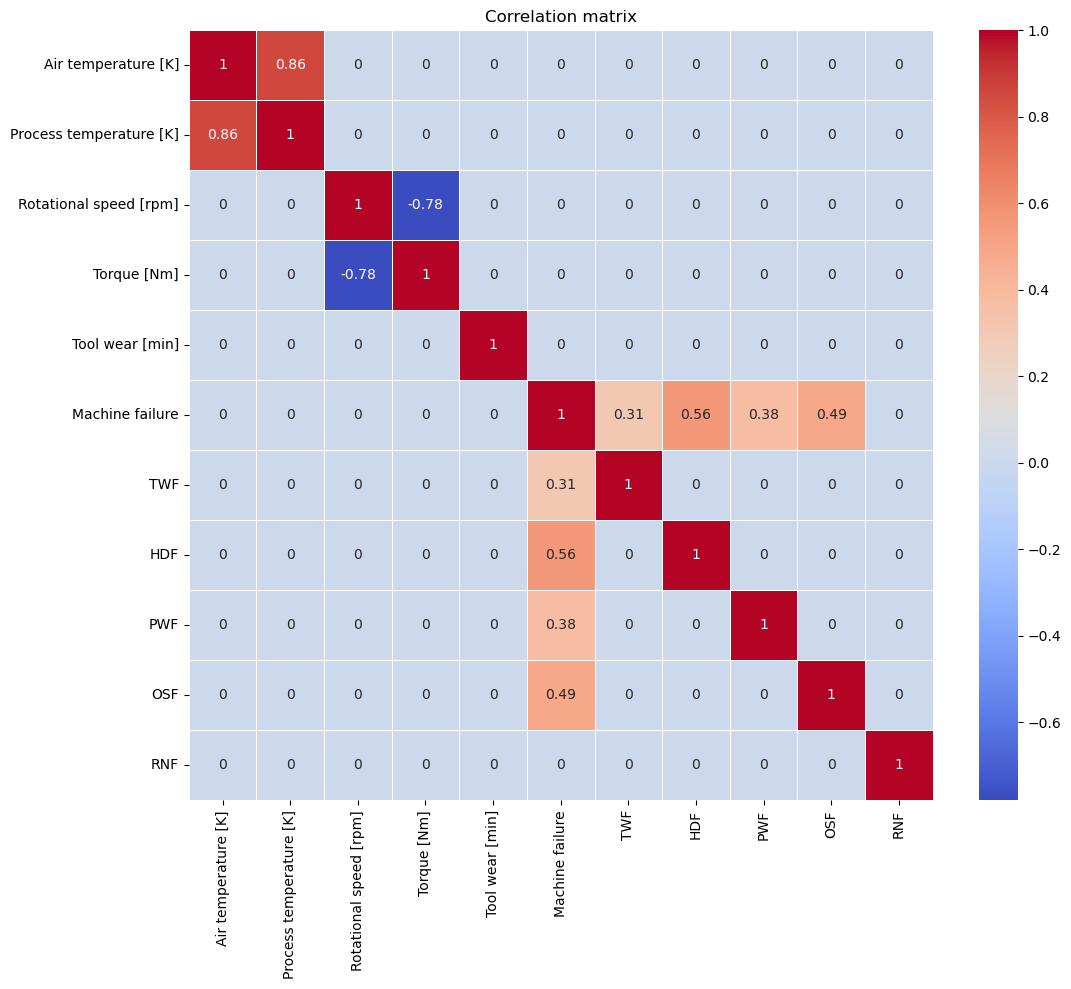

In [8]:
# draw correlations matrix

plt.figure(figsize = (12,10))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # not significant correlation
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

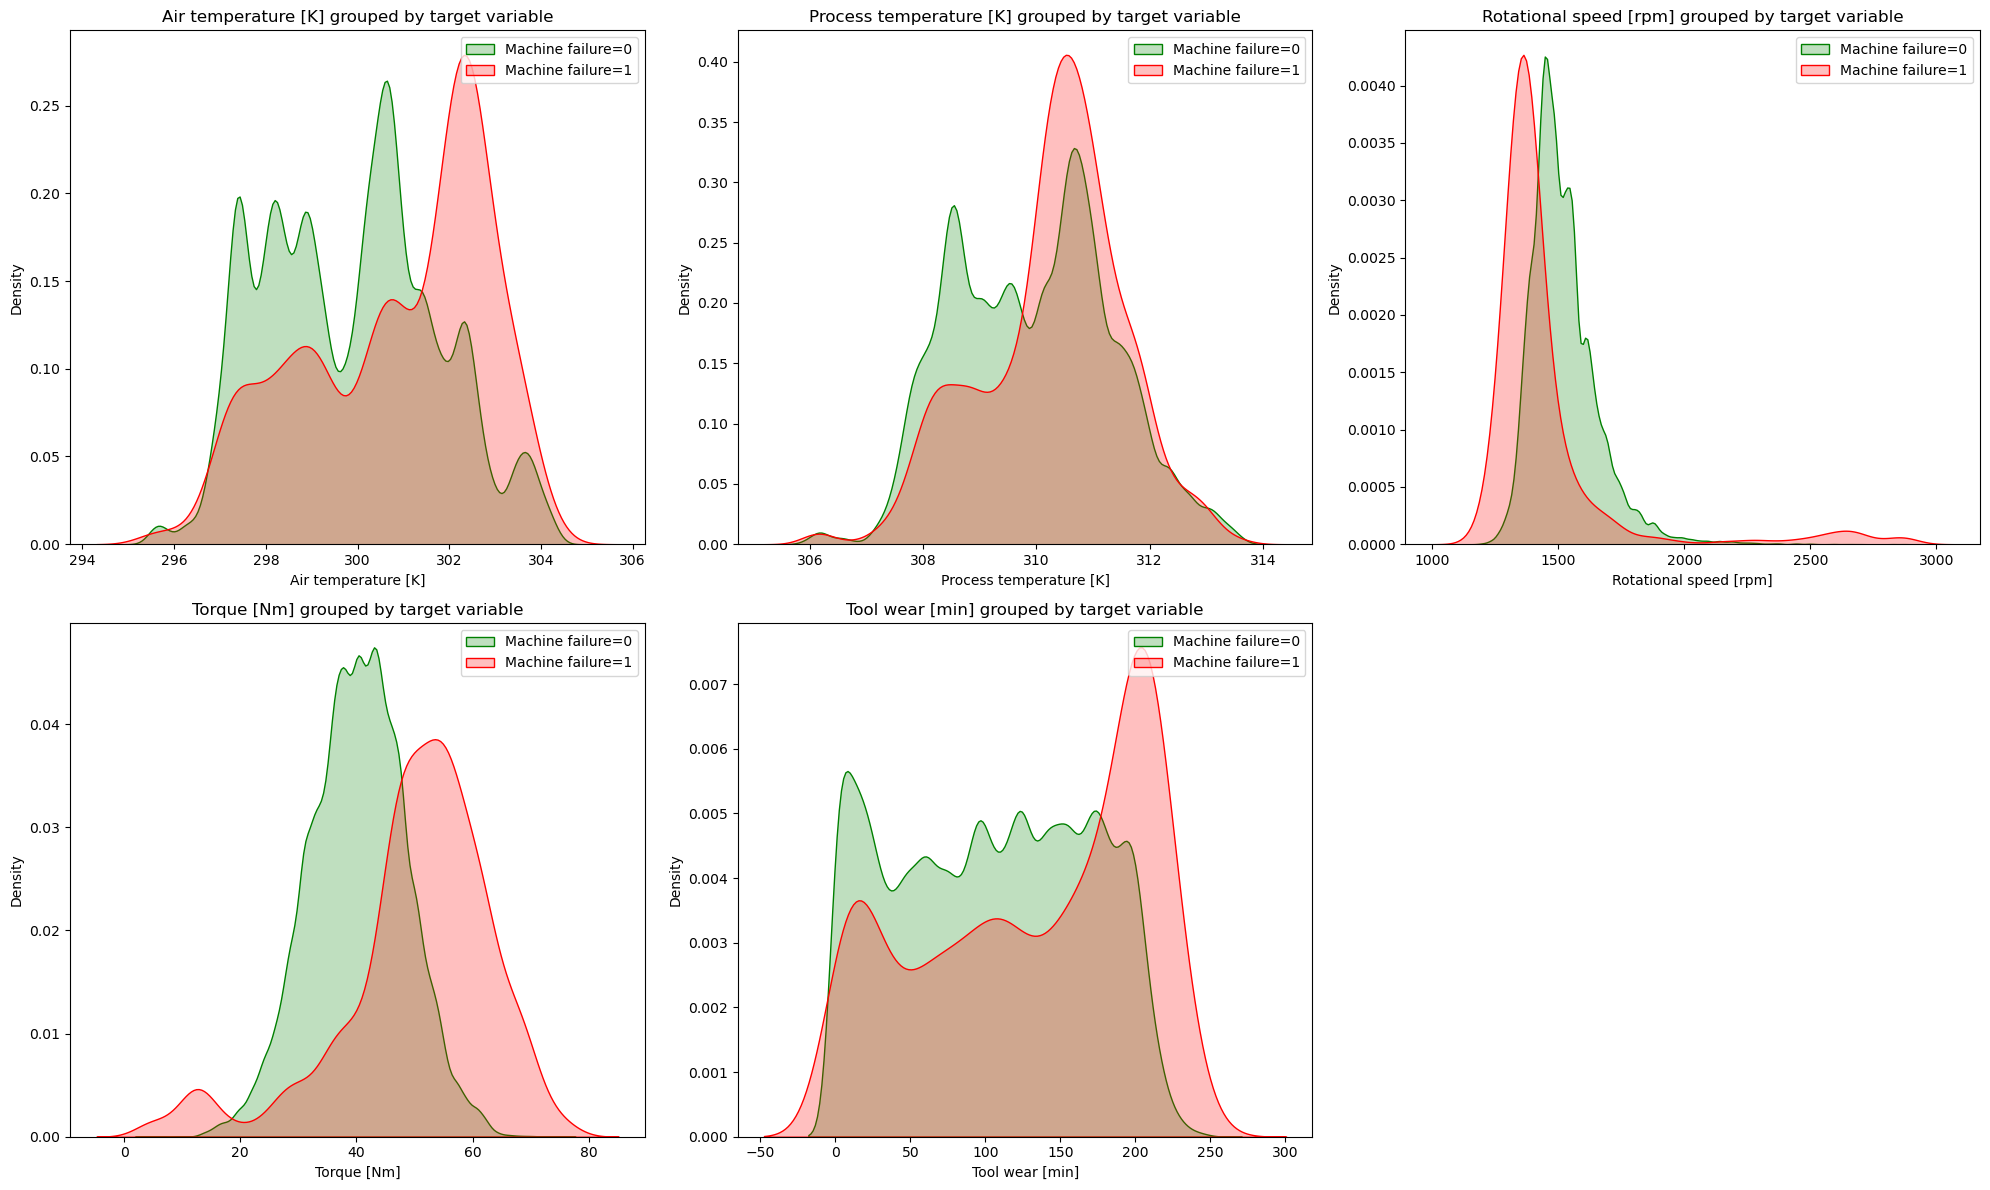

In [40]:
# inspect features distribution (values) w.r.t. target variable

plt.figure(figsize=(20, 12))
for idx, column in enumerate(numerical_features[:5], 1):
    plt.subplot(2, 3, idx)
    feature_with_target_s = df[[column, TARGET]]
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s[TARGET] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET] == 1]
    sns.kdeplot(feature_target_0, shade=True, label=f'{TARGET}=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label=f'{TARGET}=1', color='r')
    plt.xlabel(column)
    plt.title(f'{column} grouped by target variable')
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

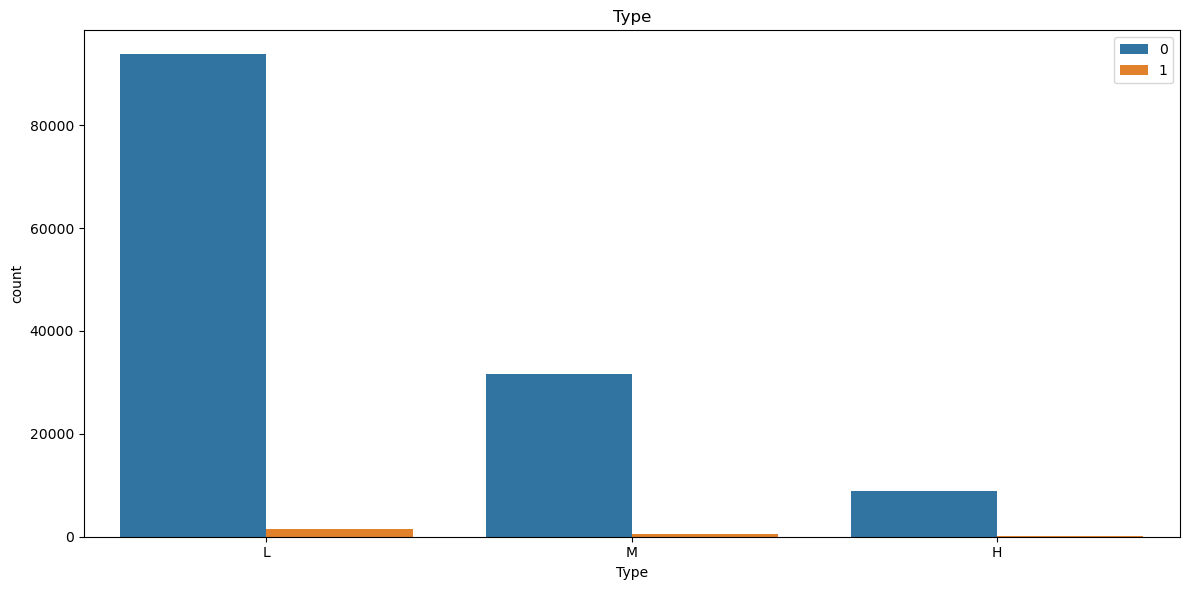

In [43]:
plt.figure(figsize=(12, 6))
plt.title(f'{cat_features[1]}')
sns.countplot(x=cat_features[1], hue=TARGET, data=df)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [44]:
table = df.reset_index().pivot_table(values='id', index="Type", columns=TARGET, aggfunc='count')
_, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
pvalue  # Type affects the target variable

4.787035816092083e-05

In [7]:
df.drop_duplicates(inplace=True)

In [49]:
df["Tool wear [min]"].value_counts()  # zero means new machine?

0      3763
2      1765
119    1440
5      1415
59     1409
       ... 
241       7
237       6
239       6
253       3
251       1
Name: Tool wear [min], Length: 246, dtype: int64

In [51]:
df[df["Tool wear [min]"] == 0].groupby(TARGET).mean()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
Machine failure,,,,,,,,,,
0,299.85372,309.907037,1520.007789,40.059414,0.0,0.0,0.00,0.000,0.0,0.001343
1,300.56000,310.012500,1433.875000,48.342500,0.0,0.1,0.35,0.125,0.2,0.000000


In [8]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: str = None,
                          suffix: str = None,
                          ) -> pd.DataFrame:
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [9]:
# next - feature engineering. Only kaggle approach. In production make aggregations, bins and statistics only on train set

# + sum binary features, np.all(axis=1); mean, max, std axis=1
# + (air - process) / air, etc. (sub/div)
# + bins (qcut): low - high
# + log features if natural outliers, add bins after log (log1p only Rotational speed [rpm], Tool wear [min])
# + aggregations: aggregate by binned features [min, max, range, mean, median, std, ]: rotation, process, air, torque, toolwear
# +ratios: +speed / hours, +torque / speed, +air / process, +torque / tool, +process temp / torque, (process - air) / rotation, (process - air) / torque
# +ratios: rotation / toolwear

# + toolwear / 60 = hours; toolwear - categories new - old [0..5]
# + Power (kW) = Torque (N.m) x Speed (RPM) / 9.5488
# + 273.15 K -> C
# + low speed + error rates interactions
# + rotation / sum_binaries, torque / sum_binaries
# select 6 best from catboost and make kaggle trick

total = pd.concat([df, test], axis=0)

total["binary_sum"] = total[["TWF", "HDF", "PWF", "OSF", "RNF"]].sum(axis=1)
total["binary_max"] = total[["TWF", "HDF", "PWF", "OSF", "RNF"]].max(axis=1)
total["binary_mean"] = total[["TWF", "HDF", "PWF", "OSF", "RNF"]].mean(axis=1)
total["binary_std"] = total[["TWF", "HDF", "PWF", "OSF", "RNF"]].std(axis=1)

total["proc_sub_air_div_proc"] = (total["Process temperature [K]"] - total["Air temperature [K]"]) / total["Process temperature [K]"]

total["tool_susp"] = np.where(total["Tool wear [min]"] == 0, 1, 0)

total["proc_bins"] = pd.cut(total["Process temperature [K]"], bins=5, labels=False)
total["air_bins"] = pd.cut(total["Air temperature [K]"], bins=5, labels=False)
total["rot_bins"] = pd.cut(total["Rotational speed [rpm]"], bins=5, labels=False)
total["torq_bins"] = pd.cut(total["Torque [Nm]"], bins=5, labels=False)
total["tool_bins"] = pd.cut(total["Tool wear [min]"], bins=5, labels=False)

total["rot_log"] = total["Rotational speed [rpm]"].apply(np.log1p)
total["rot_log_bins"] = pd.cut(total["rot_log"], bins=5, labels=False)

total["tool_log"] = total["Tool wear [min]"].apply(np.log1p)
total["tool_log_bins"] = pd.cut(total["tool_log"], bins=5, labels=False)

aggs = {
    "Rotational speed [rpm]": ["min", "max", lambda x: x.max() - x.min(), "mean", "median", "std", "count"],
    "Torque [Nm]": ["min", "max", lambda x: x.max() - x.min(), "mean", "median", "std"],
    "Tool wear [min]": ["min", "max", lambda x: x.max() - x.min(), "mean", "median", "std"],
}

for col in ["proc_bins"]: #, "air_bins", "rot_bins", "torq_bins", "tool_bins"]:
    stats = create_numerical_aggs(total, col, aggs=aggs, suffix=f"_{col}_by_proc")
    total = total.merge(stats, on=col, how="left") # .fillna(0)
    
total["tool_hours"] = total["Tool wear [min]"] / 60
total["rot_speed_ratio"] = total["Rotational speed [rpm]"] / (total["Tool wear [min]"] + 1)

total["torque_speed_ratio"] = total["Torque [Nm]"] / (total["Rotational speed [rpm]"] + 1)
total["air_proc_ratio"] = total["Air temperature [K]"] / (total["Process temperature [K]"] + 1)

total["torq_tool_ratio"] = total["Torque [Nm]"] / (total["Tool wear [min]"] + 1)
total["proc_torq_ratio"] = total["Process temperature [K]"] / (total["Torque [Nm]"] + 1)
total["rot_tool_ratio"] = total["Rotational speed [rpm]"] / (total["Tool wear [min]"] + 1)

total["temp_diff"] = total["Process temperature [K]"] - total["Air temperature [K]"]
total["temp_rot_ratio"] = (total["Process temperature [K]"] - total["Air temperature [K]"]) / (total["Rotational speed [rpm]"] + 1)
total["temp_torq_ratio"] = (total["Process temperature [K]"] - total["Air temperature [K]"]) / (total["Torque [Nm]"] + 1)

total["torq_speed_sub_div"] = (total["Rotational speed [rpm]"] - total["Torque [Nm]"]) / (total["Torque [Nm]"] + 1)
total["power"] = total["Torque [Nm]"] * total["Rotational speed [rpm]"] / 9.5488

total["proc_temp_cels"] = total["Process temperature [K]"] - 273.15

total["error_rot_interaction_sum"] = total["Rotational speed [rpm]"] * total["binary_sum"] / 5
total["error_rot_interaction_mean"] = total["Rotational speed [rpm]"] * total["binary_mean"] / 5
total["error_rot_interaction_sum_ratio"] = total["Rotational speed [rpm]"] / total["binary_sum"]

total["error_torq_interaction_sum"] = total["Torque [Nm]"] * total["binary_sum"] / 5
total["error_torq_interaction_mean"] = total["Torque [Nm]"] * total["binary_mean"] / 5
total["error_torq_interaction_mean_ratio"] = total["Torque [Nm]"] / total["binary_mean"]

In [10]:
total_scaled = StandardScaler().fit_transform(total[numerical_features].drop(TARGET, axis=1).values)

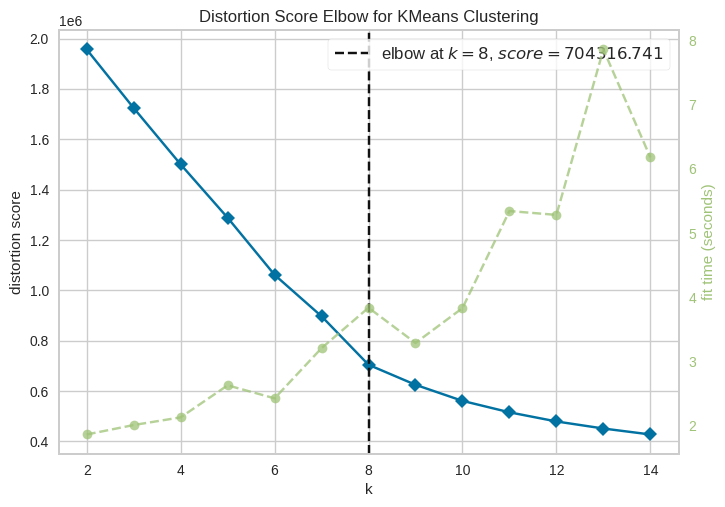

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
# scale by 2*std having binary (or one-hot) features?
 
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 15))

visualizer.fit(total_scaled) 
visualizer.show() 

In [11]:
# + KMeans distancies (StandardScaler), X['cluster_label'].apply(np.linalg.norm(cluster_centers_ - scaled_vectors)); (PCA?)
kmeans = KMeans(n_clusters=8, random_state=42).fit(total_scaled)
clusters = kmeans.predict(total_scaled)
clusters = pd.Series(data=clusters, index=total.index, name="cluster_labels")

distances = np.zeros((total_scaled.shape[0], clusters.nunique()))
for i in range(total_scaled.shape[0]):
    distances[i, :] = np.linalg.norm(kmeans.cluster_centers_ - total_scaled[i, :], axis=1)
    
distances = pd.DataFrame(data=distances, columns=[f"cent_dist{i+1}" for i in range(clusters.nunique())])

total = pd.concat([total, distances], axis=1)

In [74]:
# split by product ID: GroupKFold 1) train-valid-test 2) valid test 3) finally full data train (check (2) valid so that it is closest to test set distribution)
# check distributions after split train-valid-test-submission
# otherwise stratified split, encode "Product ID"

X, y = df.drop(TARGET, axis=1), df[TARGET]
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=123)
train_idx, valid_idx = next(iter(sgkf.split(X, y, groups=X["Product ID"])))

x_train, x_valid, y_train, y_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :], y.iloc[train_idx], y.iloc[valid_idx]

sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=123)
valid_idx, test_idx = next(iter(sgkf.split(x_valid, y_valid, groups=x_valid["Product ID"])))

x_valid, x_test, y_valid, y_test = x_valid.iloc[valid_idx, :], x_valid.iloc[test_idx, :], y_valid.iloc[valid_idx], y_valid.iloc[test_idx]

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)}, test size: {len(y_test)}")

Train size: 88829, validation size: 30993, test size: 15473


In [75]:
y_train.value_counts(normalize=True)

0    0.984217
1    0.015783
Name: Machine failure, dtype: float64

In [76]:
x_train = x_train.reset_index().set_index(["id", "Product ID"])
x_valid = x_valid.reset_index().set_index(["id", "Product ID"])
x_test = x_test.reset_index().set_index(["id", "Product ID"])
test = test.reset_index().set_index(["id", "Product ID"])

In [77]:
# check equality train-valid-test-submission, y_train, y_valid, y_test distribution
print(check_split_equality(x_train, x_valid, categorical=["Type"]))
print(check_split_equality(x_train, x_test, categorical=["Type"]))
print(check_split_equality(x_train, test, categorical=["Type"]))

(0.5691, 0.0047)
(0.5908, 0.011)
(0.5107, 0.0043)


In [12]:
df, test = total[total[TARGET].notna()], total[total[TARGET].isna()]

df = df.set_index(["Product ID"])
test = test.set_index("Product ID")

In [13]:
X, y = df.drop(TARGET, axis=1), df[TARGET]
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.3, shuffle=True, stratify=y_valid, random_state=42)

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)}, test size: {len(y_test)}")
print(check_split_equality(x_train, x_valid, categorical=["Type"]))
print(check_split_equality(x_train, x_test, categorical=["Type"]))
print(check_split_equality(x_train, test, categorical=["Type"]))

Train size: 94706, validation size: 28412, test size: 12177
(0.5015, 0.0024)
(0.502, 0.0052)
(0.4994, 0.0013)


In [19]:
y_train.value_counts(normalize=True)

0.0    0.984267
1.0    0.015733
Name: Machine failure, dtype: float64

In [14]:
cat_features = ["Type"]

In [15]:
base_params = {
        "iterations": 1000,
        "loss_function": "Logloss",  # Focal:focal_alpha=0.25;focal_gamma=2
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 6,
        "random_strength": 1,
        "rsm": 1,
        "boosting_type": "Ordered",
        "border_count": 254,
        # "bagging_temperature": 1,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": None,
        "l2_leaf_reg": 3,
        "learning_rate": 0.03,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "AUC", 
        "custom_metric": ["F1", "Logloss"],
}

In [16]:
train_pool = Pool(x_train, y_train, cat_features=["Type"])
valid_pool = Pool(x_valid, y_valid, cat_features=["Type"])
test_pool = Pool(x_test, y_test, cat_features=["Type"])

In [19]:
baseline = CatBoostClassifier(**base_params).fit(train_pool, eval_set=valid_pool)

0:	learn: 0.6102904	test: 0.6103298	best: 0.6103298 (0)	total: 225ms	remaining: 1m 52s
100:	learn: 0.0209142	test: 0.0210707	best: 0.0210707 (100)	total: 13s	remaining: 51.2s
200:	learn: 0.0194704	test: 0.0204872	best: 0.0204861 (198)	total: 25.8s	remaining: 38.4s
300:	learn: 0.0188090	test: 0.0204048	best: 0.0204047 (299)	total: 38.2s	remaining: 25.3s
400:	learn: 0.0182985	test: 0.0203401	best: 0.0203362 (397)	total: 51s	remaining: 12.6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.02032883817
bestIteration = 410

Shrink model to first 411 iterations.


In [20]:
print(classification_report(y_train, baseline.predict(x_train), digits=4))
print(classification_report(y_valid, baseline.predict(x_valid), digits=4))
print(classification_report(y_test, baseline.predict(x_test), digits=4))

print(f"Train AUC: {roc_auc_score(y_train, baseline.predict_proba(x_train)[:, 1]):.6f}")
print(f"Valid AUC: {roc_auc_score(y_valid, baseline.predict_proba(x_valid)[:, 1]):.6f}")
print(f"Test AUC: {roc_auc_score(y_test, baseline.predict_proba(x_test)[:, 1]):.6f}")

              precision    recall  f1-score   support

         0.0     0.9964    0.9999    0.9982     93216
         1.0     0.9957    0.7725    0.8700      1490

    accuracy                         0.9964     94706
   macro avg     0.9960    0.8862    0.9341     94706
weighted avg     0.9964    0.9964    0.9961     94706

              precision    recall  f1-score   support

         0.0     0.9963    0.9999    0.9981     27965
         1.0     0.9885    0.7696    0.8654       447

    accuracy                         0.9962     28412
   macro avg     0.9924    0.8847    0.9317     28412
weighted avg     0.9962    0.9962    0.9960     28412

              precision    recall  f1-score   support

         0.0     0.9963    0.9998    0.9981     11985
         1.0     0.9867    0.7708    0.8655       192

    accuracy                         0.9962     12177
   macro avg     0.9915    0.8853    0.9318     12177
weighted avg     0.9962    0.9962    0.9960     12177

Train AUC: 0.971542

In [21]:
base_params = {
        "iterations": 500,
        "loss_function": "Logloss",  # Focal:focal_alpha=0.25;focal_gamma=2
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 5,
        "random_strength": 1,
        "rsm": 0.8,
        "boosting_type": "Ordered",
        "border_count": 254,
        # "bagging_temperature": 1,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": None,
        "l2_leaf_reg": 3,
        "learning_rate": 0.03,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "Logloss", 
        "custom_metric": ["F1", "AUC"],
        "early_stopping_rounds": 30,
}

def select_features(X_tr, y_tr, X_vl, y_vl, algorithm: EFeaturesSelectionAlgorithm, steps: int = 1, select=50):
    cat_feats = X_tr.select_dtypes(include=["object", "category"]).columns.tolist()
    train_pool = Pool(X_tr, y_tr, cat_features=cat_feats)
    valid_pool = Pool(X_vl, y_vl, cat_features=cat_feats)
    
    model = CatBoostClassifier(**base_params)
    summary = model.select_features(
        train_pool,
        eval_set=valid_pool,
        features_for_select=list(range(X_tr.shape[1])),
        num_features_to_select=select,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Exact,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    return summary

feature_set = select_features(x_train, y_train,
                              x_valid, y_valid,
                              algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=40)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (40) is greater than the number of features to eliminate (22). The number of steps was reduced to 22.


In [22]:
inbuilt = feature_set["selected_features_names"]

In [ ]:
sorted(inbuilt)

In [15]:
inbuilt = [
 'Air temperature [K]',
 'HDF',
 'OSF',
 'PWF',
 'Process temperature [K]',
 'RNF',
 'ROTATIONAL SPEED [RPM]_<LAMBDA_0>_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_COUNT_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MAX_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MEAN_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MEDIAN_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MIN_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_STD_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_<LAMBDA_0>_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MAX_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MEAN_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MEDIAN_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MIN_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_STD_PROC_BINS_BY_PROC',
 'TORQUE [NM]_<LAMBDA_0>_PROC_BINS_BY_PROC',
 'TORQUE [NM]_MAX_PROC_BINS_BY_PROC',
 'TORQUE [NM]_MEAN_PROC_BINS_BY_PROC',
 'TORQUE [NM]_MIN_PROC_BINS_BY_PROC',
 'TORQUE [NM]_STD_PROC_BINS_BY_PROC',
 'TWF',
 'Tool wear [min]',
 'Torque [Nm]',
 'air_bins',
 'air_proc_ratio',
 'cent_dist1',
 'cent_dist2',
 'cent_dist3',
 'cent_dist4',
 'cent_dist5',
 'cent_dist7',
 'power',
 'proc_bins',
 'proc_sub_air_div_proc',
 'proc_temp_cels',
 'proc_torq_ratio',
 'rot_bins',
 'rot_log',
 'temp_diff',
 'temp_torq_ratio',
 'tool_bins',
 'tool_hours',
 'tool_log',
 'tool_log_bins',
 'tool_susp',
 'torq_bins'
]

In [24]:
cval = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)
imp = pd.DataFrame(index=x_train.columns.tolist())
imp2 = pd.DataFrame(index=x_train.columns.tolist())
corr = pd.DataFrame(index=x_train.columns.tolist())

x_train_val = pd.concat([x_train, x_valid], axis=0)
y_train_val = pd.concat([y_train, y_valid], axis=0)

for cnt, (tr_idx, val_idx) in enumerate(cval.split(x_train_val, y_train_val), 1):
    xtr, xvl = x_train_val.iloc[tr_idx, :], x_train_val.iloc[val_idx, :]
    ytr, yvl = y_train_val.iloc[tr_idx], y_train_val.iloc[val_idx]
    print(f"Estimating correlations, step {cnt}")
    
    run_corr = xtr.corr()
    run_corr = np.abs(run_corr).sum(axis=0)
    run_corr.name = f"corr_{cnt}"
    corr = pd.merge(corr, run_corr, right_index=True, left_index=True)
    
    trpool = Pool(xtr, ytr, cat_features=cat_features)
    vlpool = Pool(xvl, yvl, cat_features=cat_features)
    print(f"Estimating {cnt} fold")
    
    cat = CatBoostClassifier(silent=True, 
                             depth=5,
                             iterations=400,
                             allow_writing_files=False, 
                             use_best_model=True,
                             boosting_type="Ordered",
                             cat_features=cat_features,
                                                      ).fit(trpool, eval_set=vlpool, early_stopping_rounds=30)
    series = pd.Series(index=cat.feature_names_, data=cat.feature_importances_, name=f"imp_{cnt}")
    imp = pd.merge(imp, series, right_index=True, left_index=True)
    
    print(f"Estimating {cnt}-step shap-values")
    # sv = cat.get_feature_importance(trpool, reference_data=vlpool, type="ShapValues")[:, :-1]
    sv = cat.get_feature_importance(vlpool, type="ShapValues")[:, :-1] 
    series = pd.Series(data=np.abs(sv).mean(axis=0), index=xtr.columns, name=f"imp_{cnt}")
    imp2 = pd.merge(imp2, series, left_index=True, right_index=True)

imp["imp_mean"] = imp.mean(axis=1)
imp.sort_values("imp_mean", ascending=False, inplace=True)

corr["mean"] = corr.mean(axis=1)
corr.sort_values("mean", inplace=True)

imp2["mean_imp"] = imp2.mean(axis=1)
imp2.sort_values("mean_imp", ascending=False, inplace=True)

Estimating correlations, step 1
Estimating 1 fold
Estimating 1-step shap-values
Estimating correlations, step 2
Estimating 2 fold
Estimating 2-step shap-values
Estimating correlations, step 3
Estimating 3 fold
Estimating 3-step shap-values
Estimating correlations, step 4
Estimating 4 fold
Estimating 4-step shap-values
Estimating correlations, step 5
Estimating 5 fold
Estimating 5-step shap-values
Estimating correlations, step 6
Estimating 6 fold
Estimating 6-step shap-values
Estimating correlations, step 7
Estimating 7 fold
Estimating 7-step shap-values
Estimating correlations, step 8
Estimating 8 fold
Estimating 8-step shap-values
Estimating correlations, step 9
Estimating 9 fold
Estimating 9-step shap-values
Estimating correlations, step 10
Estimating 10 fold
Estimating 10-step shap-values


In [25]:
depth_range = np.arange(1, 6)
imp3 = pd.DataFrame(index=x_train.columns)

for depth in depth_range:
    model = CatBoostClassifier(depth=depth, use_best_model=True, allow_writing_files=False,
                               boosting_type="Ordered",
                               iterations=400, silent=True).fit(x_train, y_train,
                                                                eval_set=[(x_valid, y_valid),],
                                                                cat_features=cat_features, 
                                                                early_stopping_rounds=30)
    ser = pd.Series(data=model.feature_importances_, index=model.feature_names_, name=f"imp_{depth}")
    
    imp3 = pd.merge(imp3, ser, left_index=True, right_index=True)
    
imp3["mean_imp"] = imp3.mean(axis=1)
imp3.sort_values("mean_imp", ascending=False, inplace=True)  # чем раньше не-0 фича появляется тем она важнее

In [26]:
imp_model = CatBoostClassifier(depth=5, iterations=400, use_best_model=True, allow_writing_files=False,
                               boosting_type="Ordered",
                               silent=True).fit(x_train, y_train,
                                                eval_set=[(x_valid, y_valid),],
                                                cat_features=cat_features, 
                                                early_stopping_rounds=30)

fi = imp_model.get_feature_importance(Pool(x_valid, label=y_valid, 
                                           cat_features=cat_features), type="Interaction")

fi_new = []
for k, item in enumerate(fi):  
    first = x_valid.dtypes.index[fi[k][0]]
    second = x_valid.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first, second, fi[k][2]])
        
imp4 = pd.DataFrame(data=fi_new, columns=["feature1", "feature2", "strength"]).sort_values("strength", ascending=False)

In [ ]:
selected = (set(corr.head(8).index) | set(imp.head(30).index) | set(imp2.head(30).index) | set(imp3.head(20).index)) | set(inbuilt)
imp4_set = set(imp4.head(20).loc[(imp4["feature1"].isin(selected) | imp4["feature2"].isin(selected)), ["feature1", "feature2"]].values.flatten())

selected = list(selected | imp4_set)
sorted(selected)

In [16]:
selected = [
 'Air temperature [K]',
 'HDF',
 'OSF',
 'PWF',
 'Process temperature [K]',
 'RNF',
 'ROTATIONAL SPEED [RPM]_<LAMBDA_0>_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_COUNT_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MAX_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MEAN_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MEDIAN_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_MIN_PROC_BINS_BY_PROC',
 'ROTATIONAL SPEED [RPM]_STD_PROC_BINS_BY_PROC',
 'Rotational speed [rpm]',
 'TOOL WEAR [MIN]_<LAMBDA_0>_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MAX_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MEAN_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MEDIAN_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_MIN_PROC_BINS_BY_PROC',
 'TOOL WEAR [MIN]_STD_PROC_BINS_BY_PROC',
 'TORQUE [NM]_<LAMBDA_0>_PROC_BINS_BY_PROC',
 'TORQUE [NM]_MAX_PROC_BINS_BY_PROC',
 'TORQUE [NM]_MEAN_PROC_BINS_BY_PROC',
 'TORQUE [NM]_MIN_PROC_BINS_BY_PROC',
 'TORQUE [NM]_STD_PROC_BINS_BY_PROC',
 'TWF',
 'Tool wear [min]',
 'Torque [Nm]',
 'air_bins',
 'air_proc_ratio',
 'binary_max',
 'binary_mean',
 'binary_std',
 'cent_dist1',
 'cent_dist2',
 'cent_dist3',
 'cent_dist4',
 'cent_dist5',
 'cent_dist6',
 'cent_dist7',
 'cent_dist8',
 'error_rot_interaction_mean',
 'error_rot_interaction_sum',
 'error_torq_interaction_mean',
 'power',
 'proc_bins',
 'proc_sub_air_div_proc',
 'proc_temp_cels',
 'proc_torq_ratio',
 'rot_bins',
 'rot_log',
 'rot_speed_ratio',
 'rot_tool_ratio',
 'temp_diff',
 'temp_rot_ratio',
 'temp_torq_ratio',
 'tool_bins',
 'tool_hours',
 'tool_log',
 'tool_log_bins',
 'tool_susp',
 'torq_bins',
 'torq_speed_sub_div',
 'torq_tool_ratio',
 'torque_speed_ratio'
]

In [17]:
set(numerical_features) & set(selected)

{'Air temperature [K]',
 'HDF',
 'OSF',
 'PWF',
 'Process temperature [K]',
 'RNF',
 'Rotational speed [rpm]',
 'TWF',
 'Tool wear [min]',
 'Torque [Nm]'}

In [29]:
check_split_equality(x_train[inbuilt], test[inbuilt], categorical=None)

(0.4998, 0.0019)

In [18]:
numerical_features = [col for col in numerical_features if col != TARGET]

In [77]:
base_params = {
        "iterations": 1000,
        "loss_function": "Logloss",  # Focal:focal_alpha=0.25;focal_gamma=2
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 6,
        "random_strength": 0.15,
        "rsm": 0.9,
        "boosting_type": "Ordered",
        "border_count": 254,
        # "bagging_temperature": 2,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": "SqrtBalanced",
        "l2_leaf_reg": 15,
        "learning_rate": 0.05,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "Logloss", 
        "custom_metric": ["F1", "AUC"],
        "early_stopping_rounds": 30,
}

train_pool = Pool(x_train[inbuilt], y_train,)
valid_pool = Pool(x_valid[inbuilt], y_valid, )
test_pool = Pool(x_test[inbuilt], y_test,)

In [78]:
baseline = CatBoostClassifier(**base_params).fit(train_pool, eval_set=valid_pool)
preds1 = baseline.predict_proba(x_test[inbuilt])[:, 1]

0:	learn: 0.6024678	test: 0.6021451	best: 0.6021451 (0)	total: 119ms	remaining: 1m 59s
100:	learn: 0.0838008	test: 0.0902756	best: 0.0902035 (94)	total: 13s	remaining: 1m 55s
200:	learn: 0.0751203	test: 0.0898061	best: 0.0896371 (186)	total: 25.6s	remaining: 1m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.08963711744
bestIteration = 186

Shrink model to first 187 iterations.


In [79]:
print(classification_report(y_train, baseline.predict(x_train[inbuilt]), digits=4))
print(classification_report(y_valid, baseline.predict(x_valid[inbuilt]), digits=4))
print(classification_report(y_test, baseline.predict(x_test[inbuilt]), digits=4))

print(f"Train AUC: {roc_auc_score(y_train, baseline.predict_proba(x_train[inbuilt])[:, 1]):.6f}")
print(f"Valid AUC: {roc_auc_score(y_valid, baseline.predict_proba(x_valid[inbuilt])[:, 1]):.6f}")
print(f"Test AUC: {roc_auc_score(y_test, baseline.predict_proba(x_test[inbuilt])[:, 1]):.6f}")

              precision    recall  f1-score   support

         0.0     0.9971    0.9986    0.9978     93216
         1.0     0.9028    0.8168    0.8576      1490

    accuracy                         0.9957     94706
   macro avg     0.9499    0.9077    0.9277     94706
weighted avg     0.9956    0.9957    0.9956     94706

              precision    recall  f1-score   support

         0.0     0.9970    0.9987    0.9978     27965
         1.0     0.9073    0.8098    0.8558       447

    accuracy                         0.9957     28412
   macro avg     0.9521    0.9043    0.9268     28412
weighted avg     0.9956    0.9957    0.9956     28412

              precision    recall  f1-score   support

         0.0     0.9966    0.9977    0.9972     11985
         1.0     0.8483    0.7865    0.8162       192

    accuracy                         0.9944     12177
   macro avg     0.9224    0.8921    0.9067     12177
weighted avg     0.9942    0.9944    0.9943     12177

Train AUC: 0.978540

In [50]:
base_params = {
        "iterations": 1000,
        "loss_function": "Logloss",  # Focal:focal_alpha=0.25;focal_gamma=2
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 5,
        "random_strength": 0.15,
        "rsm": 0.9,
        "boosting_type": "Ordered",
        "border_count": 254,
        # "bagging_temperature": 3,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": "SqrtBalanced",
        "l2_leaf_reg": 15,
        "learning_rate": 0.05,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "Logloss", 
        "custom_metric": ["F1", "AUC"],
        "early_stopping_rounds": 30,
}

train_pool = Pool(x_train[selected], y_train,)
valid_pool = Pool(x_valid[selected], y_valid, )
test_pool = Pool(x_test[selected], y_test,)

In [51]:
baseline = CatBoostClassifier(**base_params).fit(train_pool, eval_set=valid_pool)
preds2 = baseline.predict_proba(x_test[selected])[:, 1]

0:	learn: 0.6004269	test: 0.6000462	best: 0.6000462 (0)	total: 89.6ms	remaining: 1m 29s
100:	learn: 0.0850313	test: 0.0912594	best: 0.0911743 (98)	total: 9.49s	remaining: 1m 24s
200:	learn: 0.0786365	test: 0.0900624	best: 0.0900237 (197)	total: 18.4s	remaining: 1m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.090023651
bestIteration = 197

Shrink model to first 198 iterations.


In [52]:
print(classification_report(y_train, baseline.predict(x_train[selected]), digits=4))
print(classification_report(y_valid, baseline.predict(x_valid[selected]), digits=4))
print(classification_report(y_test, baseline.predict(x_test[selected]), digits=4))

print(f"Train AUC: {roc_auc_score(y_train, baseline.predict_proba(x_train[selected])[:, 1]):.6f}")
print(f"Valid AUC: {roc_auc_score(y_valid, baseline.predict_proba(x_valid[selected])[:, 1]):.6f}")
print(f"Test AUC: {roc_auc_score(y_test, baseline.predict_proba(x_test[selected])[:, 1]):.6f}")

              precision    recall  f1-score   support

         0.0     0.9970    0.9986    0.9978     93216
         1.0     0.9009    0.8114    0.8538      1490

    accuracy                         0.9956     94706
   macro avg     0.9489    0.9050    0.9258     94706
weighted avg     0.9955    0.9956    0.9955     94706

              precision    recall  f1-score   support

         0.0     0.9969    0.9988    0.9978     27965
         1.0     0.9135    0.8031    0.8548       447

    accuracy                         0.9957     28412
   macro avg     0.9552    0.9010    0.9263     28412
weighted avg     0.9955    0.9957    0.9956     28412

              precision    recall  f1-score   support

         0.0     0.9967    0.9983    0.9975     11985
         1.0     0.8837    0.7917    0.8352       192

    accuracy                         0.9951     12177
   macro avg     0.9402    0.8950    0.9163     12177
weighted avg     0.9949    0.9951    0.9949     12177

Train AUC: 0.975121

In [26]:
def compare_models(oof_preds: list,
                   y_true: np.ndarray,
                   metric: callable,
                   n_train: int,
                   n_test: int,
                   model_names=None,
                   sample: int = 0,
                   conf_level: float = 0.95,
                   rope_interval: list = [-0.01, 0.01],
                   n_samples: int = 3000) -> pd.DataFrame:
    from scipy.stats import t, ttest_rel
    from itertools import combinations
    from math import factorial

    if model_names is None:
        model_names = [f"model_{i + 1}" for i in range(len(oof_preds))]

    n_comparisons = (factorial(len(oof_preds)) / (factorial(2) * factorial(len(oof_preds) - 2)))
    scores = [np.array(create_bootstrap_metrics(y_true, oof_pred, metric, n_samples)) for oof_pred in oof_preds]
    if sample != 0:
        scores = [np.random.choice(score, size=sample) for score in scores]

    df = scores[0].shape[0] - 1

    def corrected_std(differences, n_train, n_test):
        kr = len(differences)
        corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
        corrected_std = np.sqrt(corrected_var)
        return corrected_std

    def compute_corrected_ttest(differences, df, n_train, n_test):
        mean = np.mean(differences)
        std = corrected_std(differences, n_train, n_test)
        t_stat = mean / std
        p_val = t.sf(np.abs(t_stat), df)
        return t_stat, p_val

    pairwise_ttest, pairwise_bayesian, t_rel = [], [], []

    for model_i, model_k in combinations(range(len(scores)), r=2):
        model_i_scores = scores[model_i]
        model_k_scores = scores[model_k]

        differences = model_i_scores - model_k_scores
        t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
        p_val *= n_comparisons  # bonferroni correction
        p_val = 1 if p_val > 1 else p_val

        pairwise_ttest.append([model_names[model_i], model_names[model_k], t_stat, p_val])

        t_post = t(df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test))
        model_i_prob = t_post.cdf(rope_interval[0])  # probability of model 1 worse than 2
        model_k_prob = 1 - t_post.cdf(rope_interval[1])  # probability of model 2 worse than 1

        rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])  # probability of model 1 is equal 2

        cred_interval = list(t_post.interval(conf_level))  # true difference lies inside interval
        pairwise_bayesian.append([model_i_prob, model_k_prob, rope_prob, cred_interval[0], cred_interval[1]])

        tres = ttest_rel(model_i_scores, model_k_scores)
        statistic, p_val = tres[0], tres[1]
        # ci = tres.confidence_interval(confidence_level=0.95)

        t_rel.append([statistic, p_val])

    result = pd.DataFrame(data=np.hstack([pairwise_ttest, pairwise_bayesian, t_rel]),
                          index=[f"compare_{i + 1}" for i in range(int(n_comparisons))],
                          columns=["model_1", "model_2", "t_stat", "corr_p_val", "1_worse_2",
                                   "2_worse_1", "2_equal_1", "ci_lower", "ci_upper", "rel_stat", "non_corr_p_val"])
    result.iloc[:, 2:] = result.iloc[:, 2:].astype("float").apply(lambda x: np.round(x, 4))

    return result

In [80]:
compare_models([preds1, preds2],
                   y_true=y_test.values,
                   metric=roc_auc_score,
                   n_train=len(y_train),
                   n_test=len(y_test),
                   model_names=["inbuilt", "mix"],
                   sample=0,
                   conf_level=0.95,
                   rope_interval=[-0.01, 0.01],
                   n_samples=5000)

,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,inbuilt,mix,0.3572,0.3605,0.0066,0.0386,0.9549,-0.0075,0.0109,9.0628,0.0


In [96]:
base_params = {
        "iterations": 1000,
        "loss_function": "Logloss",
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 5,
        "random_strength": 0.15,
        "rsm": 0.9,
        "boosting_type": "Ordered",
        "border_count": 254,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": "SqrtBalanced",
        "l2_leaf_reg": 15,
        "learning_rate": 0.05,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "Logloss", 
        "custom_metric": ["F1", "AUC"],
}
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=43)
tri, vli = next(iter(cv.split(X, y)))
tr, vl = X.iloc[tri, :][inbuilt], X.iloc[vli, :][inbuilt]
ytr, yvl = y.iloc[tri], y.iloc[vli]
print(len(ytr), len(yvl))
clf = CatBoostClassifier(**base_params).fit(tr, ytr, eval_set=[(vl, yvl)], early_stopping_rounds=40)

115967 19328
0:	learn: 0.5986829	test: 0.6000869	best: 0.6000869 (0)	total: 114ms	remaining: 1m 54s
100:	learn: 0.0834513	test: 0.1102547	best: 0.1101855 (98)	total: 11.4s	remaining: 1m 41s
200:	learn: 0.0772135	test: 0.1087514	best: 0.1086481 (198)	total: 23.2s	remaining: 1m 32s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.1086481357
bestIteration = 198

Shrink model to first 199 iterations.


In [97]:
clf.get_best_iteration()

198

In [101]:
base_params = {
        "iterations": 1000,
        "loss_function": "Logloss",
        "use_best_model": True,
        "thread_count": -1,
        "silent": True,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 5,
        "random_strength": 0.15,
        "rsm": 0.9,
        "boosting_type": "Ordered",
        "border_count": 254,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": "SqrtBalanced",
        "l2_leaf_reg": 15,
        "learning_rate": 0.05,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "Logloss", 
        "custom_metric": ["F1", "AUC"],
}

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=43)

_, oof_preds, _ = catboost_cross_validation(X[inbuilt].reset_index(drop=True), 
                                            y.reset_index(drop=True), 
                                            params=base_params, 
                                            rounds=30, 
                                            cv=cv, 
                                            score_fn=roc_auc_score,
                                            calculate_ci=True, 
                                            categorical=None,
                                            textual=None,
                                            preprocess=None,
                                            best_iter="mean",
                                            check_equality=True,
                                            seed=42) 

Tue Jun 27 21:26:24 2023, Cross-Validation, 135295 rows, 50 cols
Estimating best number of trees.
Best iterations: 198 242 96 154 237 199 143
Evaluating cross validation with 181 trees.
Split check on number of tree estimation:  0.5009  +/-  0.0058
Fold 1, Train score = 0.97262, Valid score = 0.95791
Fold 2, Train score = 0.97251, Valid score = 0.96908
Fold 3, Train score = 0.97477, Valid score = 0.95331
Fold 4, Train score = 0.96944, Valid score = 0.97262
Fold 5, Train score = 0.96996, Valid score = 0.97519
Fold 6, Train score = 0.97390, Valid score = 0.95832
Fold 7, Train score = 0.96939, Valid score = 0.94891
Split check while cross-validating:  0.498  +/-  0.0045
Train score by each fold: [0.97262, 0.97251, 0.97477, 0.96944, 0.96996, 0.9739, 0.96939]
Valid score by each fold: [0.95791, 0.96908, 0.95331, 0.97262, 0.97519, 0.95832, 0.94891]
Train mean score by each fold:0.97180 +/- 0.00204
Valid mean score by each fold:0.96219 +/- 0.00936
*********************************************

In [88]:
roc_auc_score(y_test, np.vstack([preds1[None, :], preds2[None, :]]).mean(axis=0))

0.9626203761646502

In [102]:
# train full
params_full = {
        "iterations": 200,
        "loss_function": "Logloss",
        "use_best_model": False,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": 123,
        "allow_writing_files": False,
        "depth": 5,
        "random_strength": 0.15,
        "rsm": 0.9,
        "boosting_type": "Ordered",
        "border_count": 254,
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": "SqrtBalanced",
        "l2_leaf_reg": 15,
        "learning_rate": 0.05,
        "bootstrap_type": "MVS",
        "subsample": 0.8,
        "eval_metric": "Logloss"
}

model = CatBoostClassifier(**params_full).fit(X[inbuilt], y)

0:	learn: 0.5980549	total: 125ms	remaining: 24.9s
100:	learn: 0.0874644	total: 11.4s	remaining: 11.2s
199:	learn: 0.0829721	total: 23.1s	remaining: 0us


In [103]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
submission.head()

,id,Machine failure
0,136429,0.5
1,136430,0.5
2,136431,0.5
3,136432,0.5
4,136433,0.5


In [105]:
submission[TARGET] = model.predict_proba(test[inbuilt])[:,1]

In [107]:
submission.to_csv("submission.csv", index=False)

In [ ]:
# CV
# optunaCV: mean - std
# train - valid
# train full data after determing number iterations, hp and stacking mechanism (or blending): ONLY FOR KAGGLE - USE COMMON STATISTICS TRAIN-FINAL TEST
# stacking / blending